# PySpark InfluxDB Cloud 3.0 Example
## This notebook highlights how to use some baisc features of PySpark with Apache Arrow to query InfluxDB Cloud 3.0 including:
1. How to query InfluxDB Cloud and create a DataFrame with PySpark.
2. Use SQL to work with your PySpark DataFrame. 
3. How to convert a DataFrame to Parquet file for interopability with other analytics and visualization tools. 
4. Convert the PySpark DataFrame back to a Pandas DataFrame to plot the data.
5. Perform multiple linear regression with PySpark. 

### 1. How to query InfluxDB Cloud and create a DataFrame with PySpark.

In [1]:
from flightsql import FlightSQLClient
from pyspark.sql import SparkSession
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars /path/to/slf4j-nop.jar pyspark-shell'

# 1. Gather authentication credentials.
token = "JUy..XXX"
url = "us-east-1-1.aws.cloud2.influxdata.com"
database = "noaa"
query = f"SELECT * FROM 'measurementName'"

# 2. Instantiate the FlightSQL Client
client = FlightSQLClient(
    host= url,
    token= token,
    metadata={'database': database},
    features={'metadata-reflection': 'true'}
)

# 3. Execute a query against InfluxDB's Flight SQL endpoint
query = client.execute("SELECT * FROM 'airSensors' LIMIT 10")

# 4. Create reader to consume result
reader = client.do_get(query.endpoints[0].ticket)

# 5. Read all data into a PyArrow.Table
table = reader.read_all()

# 6. Convert to PySpark DataFrame
# master(master) sets the Spark master URL to connect to, such as "local" to run locally,
# and "local[*]" to run locally with all cores, or use "spark://master:7077" to run on the Spark standalone cluster.
spark = SparkSession.builder.appName("FlightSQL with PySpark") \
        .master("local[*]") \
        .getOrCreate()
df = spark.createDataFrame(table.to_pandas())

# 7. Show the DataFrame
df.show()


SLF4J: Failed to load class "org.slf4j.impl.StaticLoggerBinder".
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See http://www.slf4j.org/codes.html#StaticLoggerBinder for further details.
SLF4J: Failed to load class "org.slf4j.impl.StaticMDCBinder".
SLF4J: Defaulting to no-operation MDCAdapter implementation.
SLF4J: See http://www.slf4j.org/codes.html#no_static_mdc_binder for further details.


+-------------------+------------------+---------+-----------------+-------------------+
|                 co|          humidity|sensor_id|      temperature|               time|
+-------------------+------------------+---------+-----------------+-------------------+
| 0.5047632965896885| 35.14689785107976|  TLM0100|71.17324638495792|2023-05-10 11:42:13|
|0.48574816144255967| 35.10277318754259|  TLM0100|71.18518720926225|2023-05-10 11:42:23|
| 0.4891706306734725| 35.09675959695416|  TLM0100|71.21165391273382|2023-05-10 11:42:33|
|  0.495955495344953|35.099787209237526|  TLM0100|71.19013040886232|2023-05-10 11:42:43|
|0.49015286051386625|35.148041125814515|  TLM0100|71.23016638005292|2023-05-10 11:42:53|
| 0.4820252893254982| 35.18612764673006|  TLM0100|71.25244081747653|2023-05-10 11:43:03|
|  0.482821930445517| 35.16352520033809|  TLM0100|71.22481920637077|2023-05-10 11:43:13|
|0.46740900452974365| 35.17663373156463|  TLM0100|71.26207102074494|2023-05-10 11:43:23|
| 0.4771466795067598|

### 2.  Use SQL to work with your PySpark DataFrame. 

In [2]:
# DataFrame and Spark SQL share the same execution engine so they can be interchangeably used seamlessly. 
# For example, you can register the DataFrame as a table and run a SQL easily as below:
df.createOrReplaceTempView("dfView")
spark.sql("SELECT count(*) from dfView").show()

+--------+
|count(1)|
+--------+
|      10|
+--------+



See the following repo for how to convert Parquet to a hyper file to uplaod the files into Tableau for further analysis and forecasting:
[Tableau_InfluxDBCloud_IOx](https://github.com/InfluxCommunity/Tableau_InfluxDBCloud_IOx) 

### 4. Convert the PySpark DataFrame back to a Pandas DataFrame to plot the data.

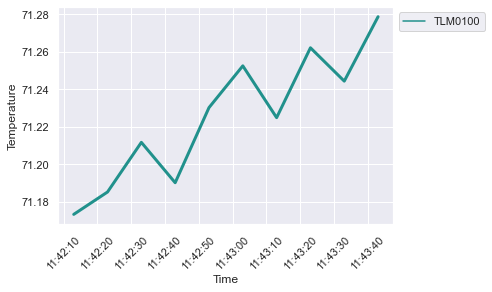

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert to pandas DataFrame for plotting
pandas_df = df.toPandas()

# Make a plot with seaborn to graph temperature values from sensor TLM0100. 
# We only selected 10 points but if we had selected more points with multple sensors this would graph them as well.
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(14,8)})

ax = sns.lineplot(data=pandas_df.reset_index(), x ='time', y = 'temperature',
                  hue='sensor_id', palette='viridis',
                  legend='full', lw=3)

plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Temperature')
plt.xlabel('Time')
plt.xticks(rotation=45)
plt.show()

### 5. Perform multiple linear regression with PySpark. 

In [4]:
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler

# Read the Data set and print the Schema:
df.printSchema()

root
 |-- co: double (nullable = true)
 |-- humidity: double (nullable = true)
 |-- sensor_id: string (nullable = true)
 |-- temperature: double (nullable = true)
 |-- time: timestamp (nullable = true)



In [5]:
# Using VectorAssembler. 
# VectorAssembler is a transformer that creates a single vector column from a list of input columns.

featureassembler = VectorAssembler (inputCols = \
                                    ["co","humidity", "temperature"], \
                                    outputCol = "Independent Features")

output = featureassembler.transform(df)

# Selecting the input and output columns:
finalised_data = output.select("Independent Features", "temperature")
# Splitting the data:
train_data, test_data = finalised_data.randomSplit([0.75, 0.25])
# Fit the model:
regressor = LinearRegression(featuresCol = 'Independent Features', labelCol = 'temperature')
regressor = regressor.fit(train_data)
# Predict:
pred_results = regressor.evaluate(test_data)
pred_results.predictions.show()

+--------------------+-----------------+-----------------+
|Independent Features|      temperature|       prediction|
+--------------------+-----------------+-----------------+
|[0.48917063067347...|71.21165391273382|71.21165391273658|
|[0.49015286051386...|71.23016638005292|71.23016638005325|
|[0.48202528932549...|71.25244081747653|71.25244081747515|
|[0.48282193044551...|71.22481920637077|71.22481920636778|
+--------------------+-----------------+-----------------+



In [6]:
pred_results = regressor.evaluate(test_data)
pred_results.predictions.show()

+--------------------+-----------------+-----------------+
|Independent Features|      temperature|       prediction|
+--------------------+-----------------+-----------------+
|[0.48917063067347...|71.21165391273382|71.21165391273658|
|[0.49015286051386...|71.23016638005292|71.23016638005325|
|[0.48202528932549...|71.25244081747653|71.25244081747515|
|[0.48282193044551...|71.22481920637077|71.22481920636778|
+--------------------+-----------------+-----------------+



The example and code above is taken from: (Linear Regression with Pyspark in 10 steps)[https://medium.com/featurepreneur/linear-regression-with-pyspark-in-10-steps-c6b3263a2c4]

### 3. Get and Read Parquet

Parquet files are a compressed columnar data format. Parquet files take very little disk space and are very fast to scan because they are column-oriented and the file format is well designed to support fast filtering. Parquet files are 16 times cheaper than CSV files. The ability to convert data from InfluxDB into Parquet offers interoperability with other tools that have Parquet support like: Tableau, PowerBI, Athena, Snowflake, DataBricks, Spark, and more.  

In [7]:
# Parquet is an efficient and compact file format to read and write faster. 
# See here to write a Parquet file:
from pyspark import pandas as ps
pandas_df.to_parquet('noaa.parquet')
# Stop PySpark
spark.stop()

/usr/local/lib/python3.9/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(
